In [1]:
from statsbombpy import sb
import numpy as np
import pandas as pd
import requests
import pymc as pm
import arviz as az

pd.options.mode.chained_assignment = None

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Import and Transformation

#### The data imports below, including the time_remaining and time_remaining_percentage, elo_difference and elo_difference/ 100, 
#### the time remaining percentage is the percentage of time remaining 

In [2]:
#Import data
data = pd.read_csv(r"C:\Users\adams\Documents\Courses\Monte_Carlo_Methods\Live_Prediction_Football_Model\data_files\final_train_data.csv", index_col=0)

home_idx, teams = pd.factorize(data.query("home_away==1")["team"])
away_idx, _ = pd.factorize(data.query("home_away==0")["team"])

coords = {"team": teams, "match": np.arange(len(data))}

data["time_remaining"] = data["max_minute_game"]-data["minute"]
data["elo_diff_better_or_worse"] = np.where(data["elo_diff"]<0, -1, 1)
data["time_remaining_percentage"] = data["time_remaining"] / data["max_minute_game"]
data["elo_diff"] = data["elo_diff"]/100

# Model Creation

#### The model generated below does the following
- Bayesian model prediction uses a poisson's distribution https://arxiv.org/pdf/1906.05029.pdf
- uses an inverse logit function 
- priors are game and contextual features  
    - Elo Difference - the difference in strength between the two teams 
    - Number of culmulative Red Cards - the number of red cards at a time interval 
    - Number of culmulative Yellow Cards - the number of yellow cards at a time interval 
    - Number of shots generated - number of culmulative shots generated at time interval t
    - Number of attacking passes - number of culmulative attacking passes, generated by team. 

Additional Considerations: 
- Percentage of time for last 10 time intervals spent in opposition final third with possession. 
- Attacking Strength of team (number of goals scored per game)/ (league avg goals scores per game)
- Defensive Strength of team (number of goals conceded per game)/(league avg goals conceded per game)


In [3]:
# Load your soccer match data into a Pandas DataFrame
# Define the PyMC3 model

import pytensor.tensor as pt

with pm.Model(coords = coords) as soccer_model:
    # Priors for model parameters (you can adjust these based on domain knowledge)

    home_data = data.query("home_away == 1")
    away_data = data.query("home_away ==0") 

    home_data["time_remaining"] = home_data["time_remaining"] + 0.1
    away_data["time_remaining"] = away_data["time_remaining"] + 0.1
    
    output_home_values = home_data["final_goals"].values
    output_away_values = away_data["final_goals"].values
    
    home = pm.Normal("home", mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    
    beta_team_goals = pm.Normal('beta_team_goals', mu=0, sigma=1)
    beta_reds = pm.Normal('beta_reds', mu=0, sigma=1)
    beta_yellows = pm.Normal('beta_yellows', mu=0, sigma=1)
    beta_score_diff = pm.Normal('beta_score_diff',mu = 0 , sigma = 1)
    beta_shots_generated = pm.Normal('beta_shots_generated', mu=0, sigma =1)
    beta_elo_diff = pm.Normal("beta_elo_diff",mu=0, sigma =1)
    beta_time_remaining = pm.HalfNormal('beta_time_remaining', sigma=1.0)
    
    # beta_goal_opportunities = pm.Normal('beta_goal_opportunities', mu=0, sigma=1)
    # beta_attacking_passes = pm.Normal('beta_attacking_passes', mu=0, sigma=1)
    # beta_expected_threat = pm.Normal('beta_expected_threat', mu=0, sigma=1)
    # beta_duel_strength = pm.Normal('beta_duel_strength', mu=0, sigma=1)

    # Linear regression model
    home_log_odds = (
        alpha +
        home +
        beta_team_goals * home_data['team_goals'] +
        beta_score_diff * home_data['score_differential'] + 
        beta_reds * home_data['red_cards'] +
        beta_yellows * home_data['yellow_cards'] +
        beta_elo_diff * home_data['elo_diff_better_or_worse'] +
        beta_shots_generated * home_data['shots_generated']
    )

    #theta --> goals within t-remaining-
    
    away_log_odds = (
        alpha +
        beta_team_goals * away_data['team_goals'] +
        beta_score_diff * away_data['score_differential'] + 
        beta_reds * away_data['red_cards'] +
        beta_yellows * away_data['yellow_cards'] +
        beta_elo_diff * away_data['elo_diff_better_or_worse'] +
        beta_shots_generated * away_data['shots_generated']
    )

    home_time_remaining = beta_time_remaining * (home_data["time_remaining_percentage"] + 0.001)
    away_time_remaining = beta_time_remaining * (away_data["time_remaining_percentage"] + 0.001)

    home_theta = pm.invlogit(home_log_odds)
    away_theta = pm.invlogit(away_log_odds)


    home_theta = pm.Deterministic('home_theta', home_theta * home_time_remaining)
    away_theta = pm.Deterministic('away_theta', away_theta * away_time_remaining)
    # home_theta = pm.Deterministic('home_theta',home_theta * home_data["time_remaining_percentage"].values)
    # away_theta = pm.Deterministic('away_theta',away_theta * away_data["time_remaining_percentage"].values)
    #defs = pm.Deterministic("away_theta", away_theta * tt.mean(home_data["time_remaining"]))
    
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=output_home_values
    )
    
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=output_away_values
    )

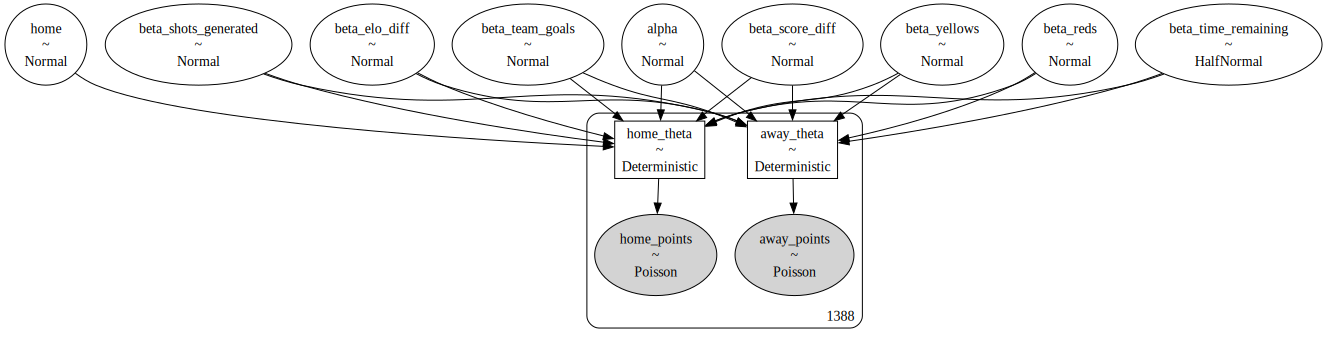

In [4]:
pm.model_to_graphviz(soccer_model)

#### Model Fit Analysis

### Plotting Functions
- allows for plotting the data by match_id or per game
- shows a line plot as percentage of time left for live probability values

### Model Probability Functions
- allows for the generation of the model final data
- returns a final model_probability dataframe value from input summary dataframe 

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from model_test_utils.utils import get_model_probability_dataframe, get_result_matrix_predictions_dataframe
from scipy.stats import poisson
# Filter out warnings by category
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_multiple_lines(line_data, x_values, labels=None, title="Line Plot"):
    """
    Plot multiple lines on the same plot using Seaborn.

    Parameters:
        line_data (list of lists): Data for each line. Each list corresponds to a line's data points.
        x_values (list): X-axis values shared by all lines.
        labels (list of str, optional): Labels for each line (legend). Default is None.
        title (str, optional): Title of the plot. Default is "Line Plot".
    """
    sns.set(style="darkgrid")
    
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot each line
    for i, data in enumerate(line_data):
        label = labels[i] if labels else f"Line {i+1}"
        sns.lineplot(x=x_values, y=data, label=label)

    # Set plot title and labels
    plt.title(title)
    plt.xlabel("Time Left Till End(%)")
    plt.ylabel("Probability (%) ")

    # Show legend if labels are provided
    if labels:
        plt.legend()

    # Show the plot
    plt.show()

def plot_by_match_id(match_id,model_probability_df, title = "Line Plot"):
    
    plot_df = model_probability_df.query(f"match_id == {match_id}")
    home_team_name = plot_df["home_team"].iloc[0]
    away_team_name = plot_df["away_team"].iloc[0]

    title = f"{away_team_name} @ {home_team_name} - Live Match Probabilities"
    
    plot_df['time_remaining_percentage_reversed'] =  plot_df['time_remaining_percentage'].tolist()[::-1]
    x_values = plot_df["time_remaining_percentage_reversed"]
    labels = ["home_win", "away_win", "draw"]
    plot_multiple_lines([list(plot_df["home_win"]), list(plot_df["away_win"]), list(plot_df["draw"])], list(x_values), labels, title=title)
    
    #sns.lineplot(x=x_values, y=list(plot_df["home_win"]), label="hello")


def create_model_probability_dataframe(trace, summary_df):
    home_summary_df = summary_df[summary_df["index"].str.contains("away")]
    away_summary_df = summary_df[summary_df["index"].str.contains("away")]

    home_rename_cols = {
            "team_id":"home_id",
            "team":"home_team",
            "final_goals":"home_final_goals",
            "team_goals":"home_team_goals",
            "score_differential":"home_score_diff"
        }
    
    away_rename_cols = {
            "team_id":"away_id",
            "team":"away_team",
            "final_goals":"away_final_goals",
            "team_goals":"away_team_goals",
            "score_differential":"away_score_diff"
    }
    
    groupby_cols = ["match_id","minute","time_remaining","time_remaining_percentage"]
    
    home_cols = groupby_cols + [col for col in home_rename_cols.values()]
    away_cols = groupby_cols + [col for col in away_rename_cols.values()]
    
    temp_home = home_data.rename(columns = home_rename_cols)[home_cols]
    temp_away = away_data.rename(columns = away_rename_cols)[away_cols]

    temp_home["home_theta"] = list(home_summary_df["mean"])
    temp_away["away_theta"] = list(away_summary_df["mean"])

    x_list = range(0, 5)
    combined_df = pd.merge(temp_home, temp_away, on = groupby_cols)
    combined_df["home_probabilities"] = combined_df["home_theta"].apply(lambda y: [poisson.pmf(x, y) for x in x_list])
    combined_df["away_probabilities"] = combined_df["away_theta"].apply(lambda y: [poisson.pmf(x, y) for x in x_list])

    model_probability_df = get_result_matrix_predictions_dataframe(combined_df, x_list)

    return model_probability_df


#### Using nutpie 

In [203]:
import nutpie 

compiled_model = nutpie.compile_pymc_model(soccer_model)
trace = nutpie.sample(compiled_model)

array([[<Axes: title={'center': 'home'}>,
        <Axes: title={'center': 'home'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_team_goals'}>,
        <Axes: title={'center': 'beta_team_goals'}>],
       [<Axes: title={'center': 'beta_reds'}>,
        <Axes: title={'center': 'beta_reds'}>],
       [<Axes: title={'center': 'beta_yellows'}>,
        <Axes: title={'center': 'beta_yellows'}>],
       [<Axes: title={'center': 'beta_shots_generated'}>,
        <Axes: title={'center': 'beta_shots_generated'}>],
       [<Axes: title={'center': 'beta_elo_diff'}>,
        <Axes: title={'center': 'beta_elo_diff'}>],
       [<Axes: title={'center': 'beta_time_remaining'}>,
        <Axes: title={'center': 'beta_time_remaining'}>]], dtype=object)

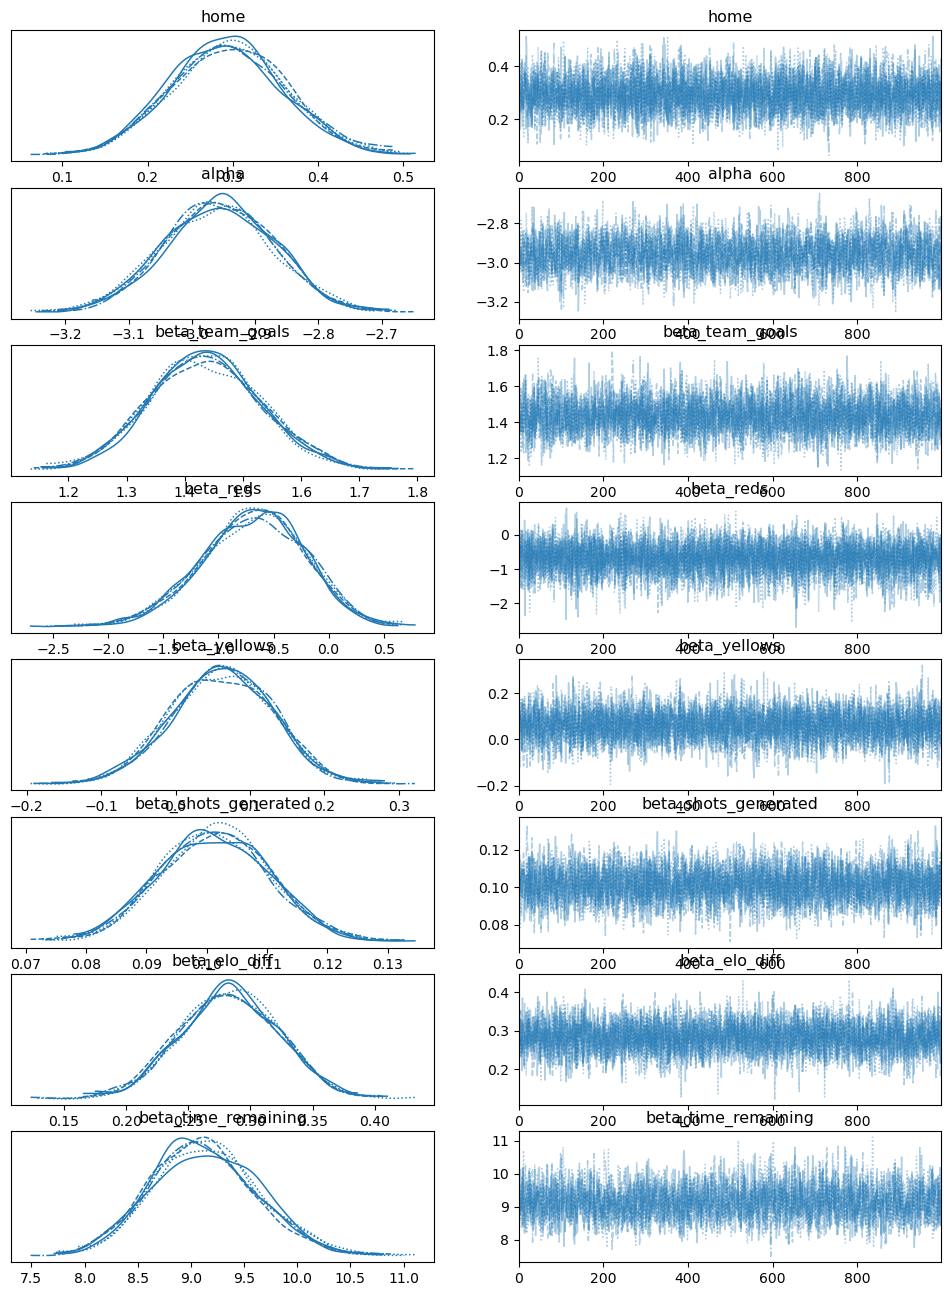

In [12]:
columns = ["home","alpha","beta_team_goals","beta_reds","beta_yellows","beta_shots_generated","beta_elo_diff","beta_time_remaining"]
az.plot_trace(trace_nutepie,var_names = columns)

array([[<Axes: title={'center': 'home'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_team_goals'}>,
        <Axes: title={'center': 'beta_reds'}>],
       [<Axes: title={'center': 'beta_yellows'}>,
        <Axes: title={'center': 'beta_shots_generated'}>,
        <Axes: title={'center': 'beta_elo_diff'}>,
        <Axes: title={'center': 'beta_time_remaining'}>]], dtype=object)

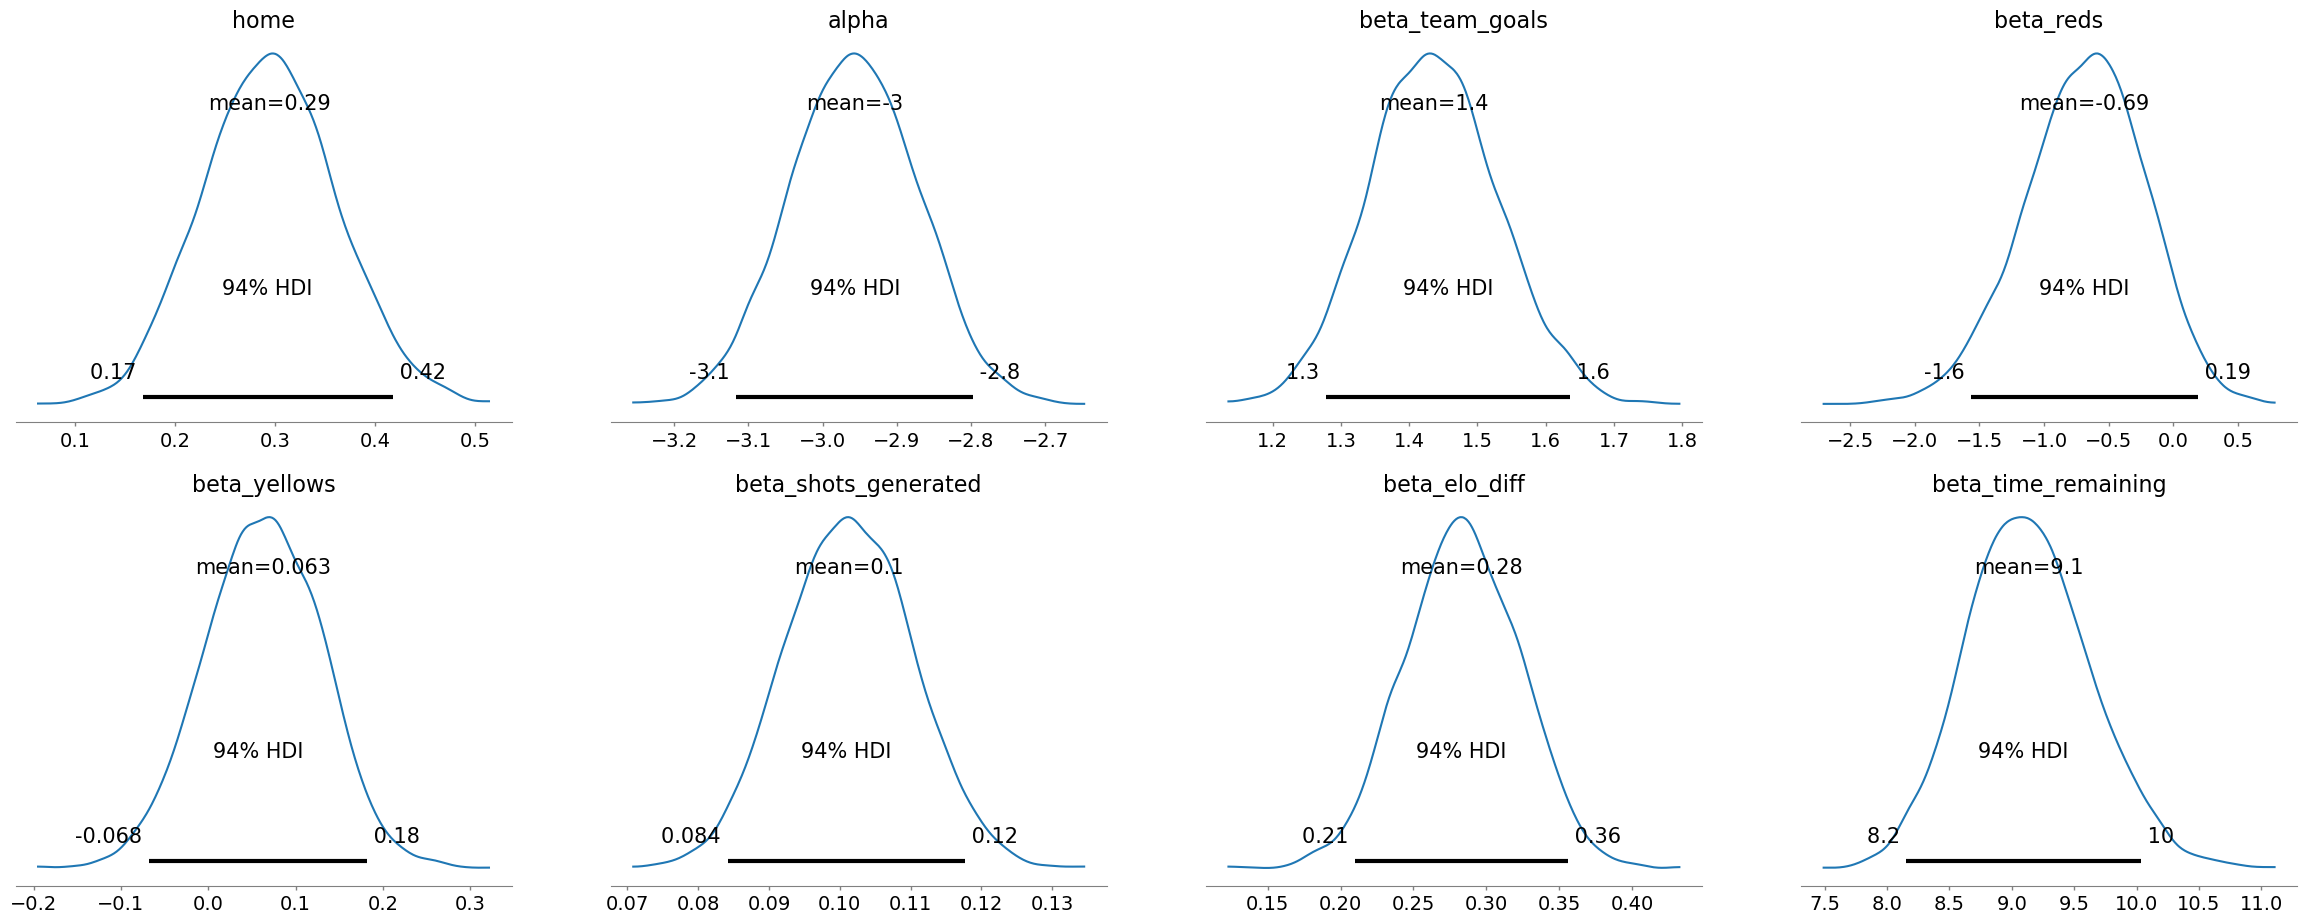

In [13]:
az.plot_posterior(trace_nutepie, var_names = columns)

In [9]:
summary = pm.summary(trace_nutepie)
summary_df = summary.reset_index()

In [19]:
home_summary_df = summary_df[summary_df["index"].str.contains("away")]
away_summary_df = summary_df[summary_df["index"].str.contains("away")]

In [67]:
home_rename_cols = {
        "team_id":"home_id",
        "team":"home_team",
        "final_goals":"home_final_goals",
        "team_goals":"home_team_goals",
        "score_differential":"home_score_diff"
    }

away_rename_cols = {
        "team_id":"away_id",
        "team":"away_team",
        "final_goals":"away_final_goals",
        "team_goals":"away_team_goals",
        "score_differential":"away_score_diff"
}

groupby_cols = ["match_id","minute","time_remaining","time_remaining_percentage"]

home_cols = groupby_cols + [col for col in home_rename_cols.values()]
away_cols = groupby_cols + [col for col in away_rename_cols.values()]

temp_home = home_data.rename(columns = home_rename_cols)[home_cols]
temp_away = away_data.rename(columns = away_rename_cols)[away_cols]

In [68]:
temp_home["home_theta"] = list(home_summary_df["mean"])
temp_away["away_theta"] = list(away_summary_df["mean"])

In [81]:
model_probability_df = get_result_matrix_predictions_dataframe(combined_df, x_list)

In [189]:
import ipywidgets as widgets
from IPython.display import display

# Function to display the selected value
def display_selected_value(selected_option):
    print("Selected value:", selected_option)
    plot_by_match_id(selected_option, model_probability_df)

# Dropdown widget with the display function as the callback
dropdown = widgets.Dropdown(
    options=model_probability_df["match_id"].unique().tolist(),
    description="Select an option:"
)

# Use interact to automatically update the display function
widgets.interact(display_selected_value, selected_option=dropdown)

interactive(children=(Dropdown(description='Select an option:', options=(3754058, 3754245, 3754037, 3754039, 3…

<function __main__.display_selected_value(selected_option)>

In [206]:
ppc = pm.sample_posterior_predictive(trace, model=soccer_model)

Sampling: [away_points, home_points]


array([<Axes: xlabel='home_points / home_points'>,
       <Axes: xlabel='away_points / away_points'>], dtype=object)

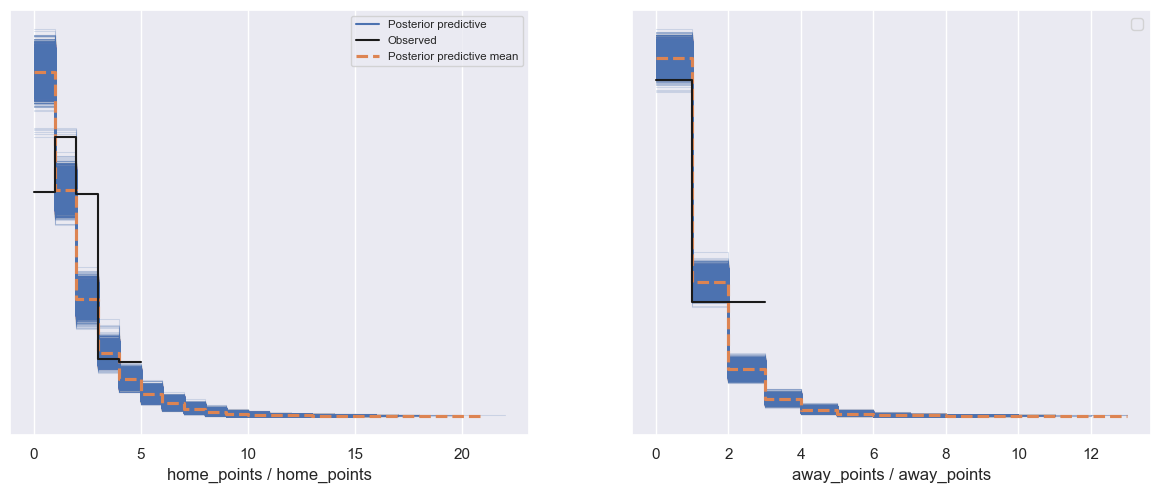

In [214]:
az.plot_ppc(ppc)